<h1 style="color: #001a79;">Anomaly Detection using Keras</h1>

<hr style="border-top: 1px solid #001a79;" />

** making a start to this notebook

Link to keras - timeseries anomaly detection here. Start research! 

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

**TO DO:**

- On the keras5 website, there is an example of time-series anomaly detection  


- Re-create this example in a notebook of your own, explaining the concepts


- clearly explain each keras function used, referring to the documentation.


<h2 style="color: #001a79;">Introduction</h2>

<hr style="border-top: 1px solid #001a79;" />

**TO DO:**

Include an introduction to your notebook, setting the context and
describing what the reader can expect as they read down through
the notebook.


**CLEAN UP**

`It tries to learn a smaller representation of its input (encoder) and then reconstruct its input from that smaller representation (decoder). An anomaly score is designed to correspond to the reconstruction error.`

Nice article here: https://thingsolver.com/time-series-anomaly-detection-using-a-variational-autoencoder-vae/#:~:text=It%20tries%20to%20learn%20a,)%2C%20a%20Bayesian%20neural%20network.

This notebook is a re-creation of the timeseries anomaly detection using an Autoencoder in my own words. All code can be found on offical documentation here: https://keras.io/examples/timeseries/timeseries_anomaly_detection/

The goal is to display how we can reconstruct convilutional autoencoder model to detect anomalies using a timeseries.

In other words, we will use keras on top of tensorflow to build and train a model and then detect the anomolies. 

<h3 style="color: #001a79;">Importing Modules</h3>

<hr style="border-top: 1px solid #001a79;" />

In [1]:
# For numerical arrrays.
import numpy as np

# Dealing with dataframes. 
import pandas as pd

# For detectign anomolies.
from tensorflow import keras

# For building and training a models.
from tensorflow.keras import layers

# For data visualisation. 
from matplotlib import pyplot as plt

<h3 style="color: #001a79;">TensorFlow</h3>


Tensorflow is a platform widely using in machine learning and statistics. It purpose is to aid with data automation, model tracking, performance monitoring and model retraining. 

Offical documentation can be found here: https://www.tensorflow.org/learn

<h3 style="color: #001a79;">Keras</h3>


Keras is a deep learning API which runs on top of TensorFlow. It's purpose is to provide a simple and flexible way of experimenting with ideas and producing fast results. It is an important library for completeing research. 


Offical documentation can be accessed here: https://keras.io/


<h3 style="color: #001a79;">Loading the Data</h3>

<hr style="border-top: 1px solid #001a79;" />

For this experiment we will use the Numenta Anomaly Benchmark(NAB) dataset which can be found [here](https://www.kaggle.com/datasets/boltzmannbrain/nab). This dataset is an artifical timeseries where the data is ordered, timestamped and has single-valued metrics. It contains labelled anomalour periods of behaviour which is what makes it so simple and effective.

There are two csv files associated with this dataset which we will use for training and testing of data. 

In [16]:
# Loading the data. 

master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

# Using csv for training. 
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(df_small_noise_url, parse_dates=True, index_col="timestamp")

# Using csv for testing. 
df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url, parse_dates=True, index_col="timestamp")

In [17]:
# Check the data. 

# Print data for training. 
print(df_small_noise.head())

# Print data for testing. 
print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


<h3 style="color: #001a79;">Plotting the Data</h3>

<hr style="border-top: 1px solid #001a79;" />

<h3 style="color: #001a79;">Timeseries data without anomalies</h3>

The data in Figure 1 will be used for training. 

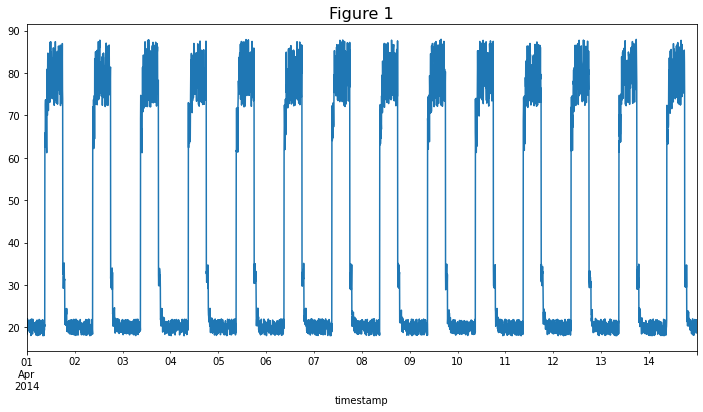

In [23]:
# Plot without anomalies. 

fig, ax = plt.subplots(figsize=(12,6))
df_small_noise.plot(legend=False, ax=ax)
plt.title("Figure 1", size=16)
plt.show()

<h3 style="color: #001a79;">Timeseries data with anomalies</h3>

This data will be used for testing. The idea is to check if the sudden jump which can be seen below in Figure 2 will be detected as an anomaly. 

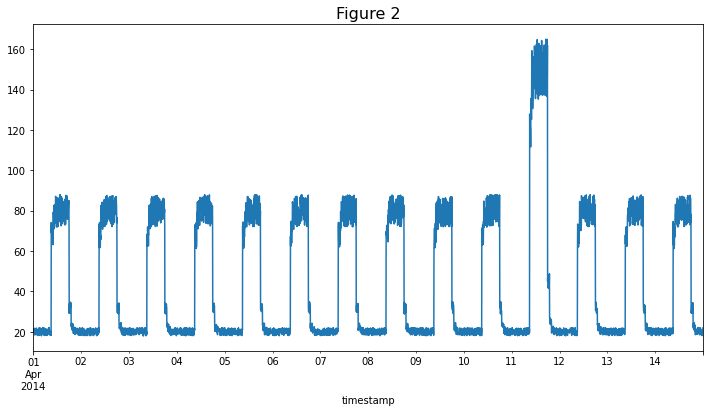

In [24]:
# Plot with anomalies. 

fig, ax = plt.subplots(figsize=(12,6))
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.title("Figure 2", size=16)
plt.show()

<h3 style="color: #001a79;">Building a Model</h3>

<hr style="border-top: 1px solid #001a79;" />

In [6]:
# Prepare training data

# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [7]:
# Create sequences

TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [8]:
# Build a model

model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [9]:
# Train the model

history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 11s 237ms/step - loss: 0.4889 - val_loss: 0.0757
Epoch 2/50
27/27 [==============================] - 5s 165ms/step - loss: 0.0795 - val_loss: 0.0431
Epoch 3/50
27/27 [==============================] - 4s 152ms/step - loss: 0.0587 - val_loss: 0.0373
Epoch 4/50
27/27 [==============================] - 4s 156ms/step - loss: 0.0512 - val_loss: 0.0329
Epoch 5/50
27/27 [==============================] - 4s 156ms/step - loss: 0.0448 - val_loss: 0.0301
Epoch 6/50
27/27 [==============================] - 4s 155ms/step - loss: 0.0399 - val_loss: 0.0271
Epoch 7/50
27/27 [==============================] - 4s 154ms/step - loss: 0.0358 - val_loss: 0.0253
Epoch 8/50
27/27 [==============================] - 4s 154ms/step - loss: 0.0328 - val_loss: 0.0240
Epoch 9/50
27/27 [==============================] - 4s 157ms/step - loss: 0.0304 - val_loss: 0.0242
Epoch 10/50
27/27 [==============================] - 4s 156ms/step - loss: 0.0284 - val_loss: 0.023

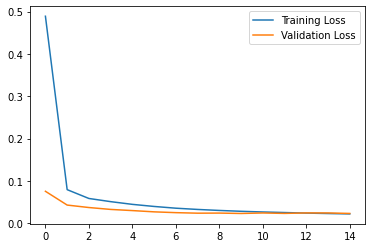

In [10]:
# Let's plot training and validation loss to see how the training went.

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

<h3 style="color: #001a79;">Detecting Anomalies</h3>

<hr style="border-top: 1px solid #001a79;" />

118/118 [==============================] - 3s 22ms/step


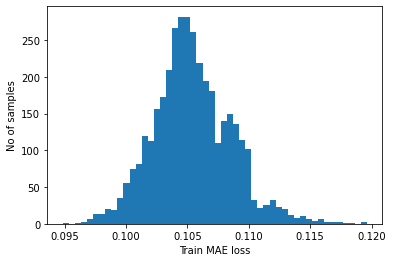

Reconstruction error threshold:  0.11961776323391132


In [11]:
# Detecting anomalies

# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

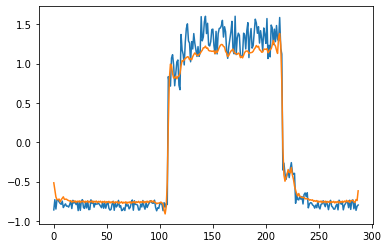

In [12]:
# Compare recontruction

# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

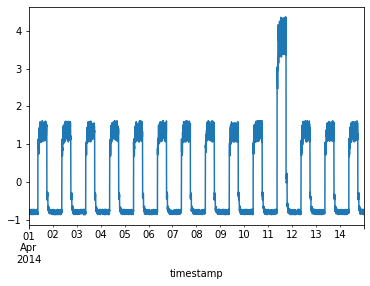

Test input shape:  (3745, 288, 1)
118/118 [==============================] - 3s 22ms/step


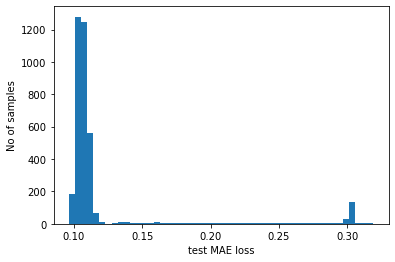

Number of anomaly samples:  403
Indices of anomaly samples:  (array([ 789, 1651, 1653, 1654, 1659, 2517, 2518, 2519, 2523, 2702, 2703,
       2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714,
       2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725,
       2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736,
       2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747,
       2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758,
       2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769,
       2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780,
       2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791,
       2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802,
       2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813,
       2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824,
       2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2

In [13]:
# Prepare test data

df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [14]:
# Plot anomalies

# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

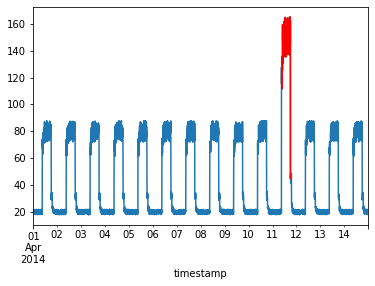

In [15]:
# Let's overlay the anomalies on the original test data plot.

df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

<h2 style="color: #001a79;">Conclusion</h2>

<hr style="border-top: 1px solid #001a79;" />

To do:

Include a conclusion section where you suggest improvements you
could make to the analysis in the notebook.


<hr style="border-top: 1px solid #001a79;" />

<h2 style="color: #001a79;">End</h2>